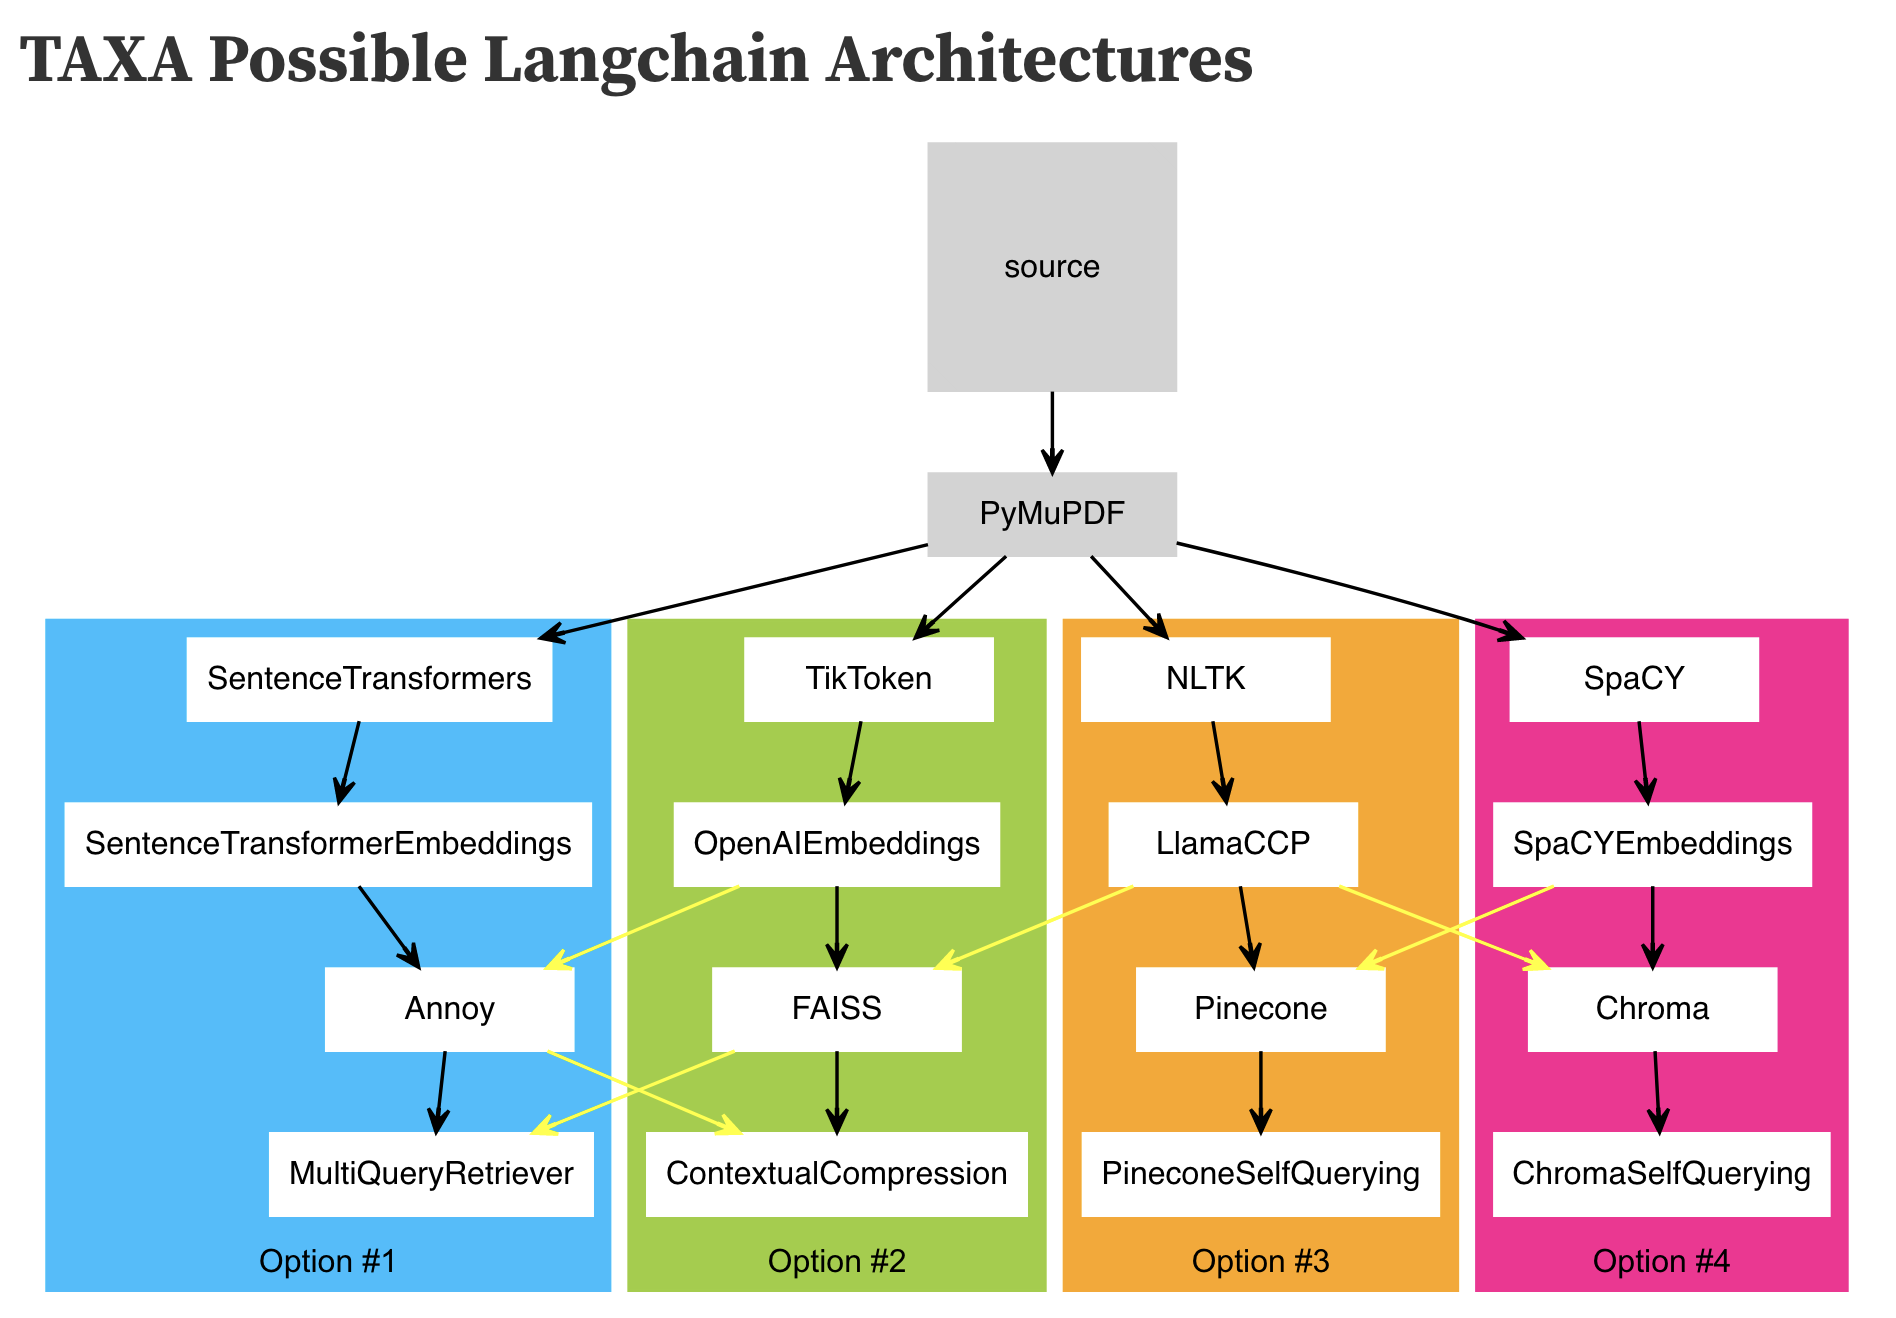

In [1]:
import pandas as pd
import os
import openai
import sys, pathlib, fitz
from langchain.chains import LLMChain
from langchain.chains.question_answering import load_qa_chain
from langchain.chains import RetrievalQA
from langchain.chains import ConversationalRetrievalChain
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.text_splitter import TokenTextSplitter
from langchain.embeddings.openai  import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.retrievers.document_compressors import LLMChainFilter
from langchain.chat_models import ChatOpenAI
from langchain.memory import VectorStoreRetrieverMemory
from langchain.memory import ConversationBufferMemory
from langchain import PromptTemplate
from langchain.chains.qa_with_sources import load_qa_with_sources_chain
from langchain.chains.conversational_retrieval.prompts import CONDENSE_QUESTION_PROMPT
# from langchain.prompts.chat import (
#     ChatPromptTemplate,
#     SystemMessagePromptTemplate,
#     AIMessagePromptTemplate,
#     HumanMessagePromptTemplate,
# )
# from langchain.schema import AIMessage, HumanMessage, SystemMessage

In [2]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

In [3]:
# Helper function for printing docs

def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))

In [4]:
def has_citations(page_text):
    # List of variations of "citations" to check for
    citation_variations = ["Citations", "Literature Cited", "Literature Citations"]

    for variation in citation_variations:
        if variation in page_text:
            return True
    return False

def remove_citation_pages(pdf_path):
    doc = fitz.open(pdf_path)
    non_citation_pages = []

    for page_num in range(doc.page_count):
        page = doc[page_num]
        page_text = page.get_text()

        if not has_citations(page_text):
            non_citation_pages.append(page_num)

    # Create a new PDF with only non-citation pages
    new_pdf = fitz.open()
    for page_num in non_citation_pages:
        new_pdf.insert_pdf(doc, from_page=page_num, to_page=page_num)

    return new_pdf


input_pdf_path = './hms/fhl_2014_Charifson_34622 (1).pdf'

# Create a new PDF with citation pages removed
new_pdf = remove_citation_pages(input_pdf_path)

# Save the new PDF to 'output.pdf'
output_pdf_path = 'output.pdf'
new_pdf.save(output_pdf_path)
new_pdf.close()


In [5]:
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    doc.close()
    return text

# Replace 'output.pdf' with the path to the PDF you created with citation pages removed
new_pdf_path = 'output.pdf'

# Extract text from the new PDF
new_pdf_text = extract_text_from_pdf(new_pdf_path)

# Now you can manipulate the extracted text or perform any other actions as needed
# For example, you can print the extracted text:
print(new_pdf_text)

Charifson 1 
 
Snail Predation by Hemigrapsus nudus and Hemigrapsus oregonensis: Sex and Species 
Differences in Chela Size. 
 
David Charifson1,2 
 
Marine Invertebrate Zoology 
Summer 2014 
 
 
 
 
1 Friday Harbor Laboratories, University of Washington, Friday Harbor, WA 98250 
2 Department of Ecology and Evolution, Stony Brook University, Stony Brook, NY 11794-5245 
 
 
 
 
Contact information: 
David Charifson 
Department of Ecology and Evolution 
Stony Brook University 
650 Life Sciences Building 
Stony Brook, NY 11794-5245 
David.charifson@stonybrook.edu  
 
 
 
 
Keywords: Hemigrapsus nudus, Hemigrapsus orogenensis, Littorina scutulata, Lacuna vincta, 
predation, sexual dimorphism, character displacement  
 
 
Charifson 2 
 
Abstract: 
 
The relationship between propus size and use of snails as prey in sympatric populations 
of Hemigrapsus nudus and Hemigrapsus oregonensis was investigated. Propal height and propal 
width increases with body size in a predictable manner in male 

In [7]:
# Read in some Data
loader = PyMuPDFLoader("hms/fhl_2014_Charifson_34622 (1).pdf")

# Now taht we have our PDF document loaded into a loader object, we move onto text splitters
pages = loader.load_and_split()

In [5]:
# with open("hms/kr111tr5711.txt",  encoding="utf8") as f:
#     text_file = f.read()

# Tiktoken Splitter

tiktoken is a fast byte pair encoding (BPE) tokenizer created by OpenAI.

We can use it to estimate tokens used. It will probably be more accurate for the OpenAI models.

 - How the text is split: by character passed in
 - How the chunk size is measured: by tiktoken tokenizer

Models don't see text like humans, instead they see a sequence of numbers (known as tokens). Byte pair encoding (BPE) is a way of converting text into tokens. It has a couple desirable properties:

 - It's reversible and lossless, so you can convert tokens back into the original text
 - It works on arbitrary text, even text that is not in the tokeniser's training data
 - It compresses the text: the token sequence is shorter than the bytes corresponding to the original text. On average, in practice, each token corresponds to about 4 bytes.
 - It attempts to let the model see common subwords. For instance, "ing" is a common subword in English, so BPE encodings will often split "encoding" into tokens like "encod" and "ing" (instead of e.g. "enc" and "oding"). Because the model will then see the "ing" token again and again in different contexts, it helps models generalise and better understand grammar.


[AttributeError: 'str' object has no attribute 'page_content](https://github.com/langchain-ai/langchain/issues/3799)

docs2 = tk_text_splitter.split_text(text_file) --> tk_text_splitter.create_documents(text_file)

In [10]:
#load a tiktoken splitter directly
from langchain.text_splitter import TokenTextSplitter

tk_text_splitter = TokenTextSplitter(chunk_size = 200, chunk_overlap = 0)

docs2 = tk_text_splitter.split_documents(pages)

print(docs2[0])

page_content='Charifson 1 \n \nSnail Predation by Hemigrapsus nudus and Hemigrapsus oregonensis: Sex and Species \nDifferences in Chela Size. \n \nDavid Charifson1,2 \n \nMarine Invertebrate Zoology \nSummer 2014 \n \n \n \n \n1 Friday Harbor Laboratories, University of Washington, Friday Harbor, WA 98250 \n2 Department of Ecology and Evolution, Stony Brook University, Stony Brook, NY 11794-5245 \n \n \n \n \nContact information: \nDavid Charifson \nDepartment of Ecology and Evolution \nStony Brook University \n650 Life Sciences Building \nStony Brook, NY 11794-5245 \nDavid.charifson@stonybrook.edu  \n \n \n \n \nKeywords: Hemig' metadata={'source': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'file_path': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'page': 0, 'total_pages': 19, 'format': 'PDF 1.5', 'title': '', 'author': 'David', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Office Word 2007', 'producer': 'Microsoft® Office Word 2007', 'creationDate': "D:20140723120649-04'00'", 'modDat

In [11]:
#Initialize Embeddings
embeddings = OpenAIEmbeddings()

## FAISS Vectorstore

Faiss is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. It also contains supporting code for evaluation and parameter tuning.

To retrieve text, there are two search types you can choose: 

 - search_type="similarity" uses similarity search in the retriever object where it selects text chunk vectors that are most similar to the question vector. 
 
 - search_type="mmr" uses the maximum marginal relevance search where it optimizes for similarity to query AND diversity among selected documents.

In our case, we wouldnt want to much diversity in our documents as we want the most accurate information. K = 3 returns the 3 most relevant documents.

As you will see, there are some inconsistencies in K as some returned 1, 2, or more than 3 relevant documents.

In [12]:
vector_store = FAISS.from_documents(docs2, embeddings).as_retriever(search_type = "similarity", search_kwargs= {"k": 3})

# Contextual compression

One challenge with retrieval is that usually you don't know the specific queries your document storage system will face when you ingest data into the system. This means that the information most relevant to a query may be buried in a document with a lot of irrelevant text. Passing that full document through your application can lead to more expensive LLM calls and poorer responses.

Contextual compression is meant to fix this. The idea is simple: instead of immediately returning retrieved documents as-is, you can compress them using the context of the given query, so that only the relevant information is returned. “Compressing” here refers to both compressing the contents of an individual document and filtering out documents wholesale.

To use the Contextual Compression Retriever, you'll need:

 - a base Retriever
 - a Document Compressor
 
The Contextual Compression Retriever passes queries to the base Retriever, takes the initial documents and passes them through the Document Compressor. The Document Compressor takes a list of Documents and shortens it by reducing the contents of Documents or dropping Documents altogether.

### Adding contextual compression with an LLMChainExtractor

Now let's wrap our base retriever with a ContextualCompressionRetriever. We'll add an LLMChainExtractor, which will iterate over the initially returned documents and extract from each only the content that is relevant to the query.

In [13]:
'''We wrapped our base retriever with a ContextualCompressionRetriever. Also added LLMChainExtractor, which will iterate
over the initially returned documents and extract from each only the content that is relevant to the query'''

llm = ChatOpenAI(temperature=0, model_name='gpt-3.5-turbo')

compressor = LLMChainExtractor.from_llm(llm)

compression_retriever = ContextualCompressionRetriever(base_compressor = compressor,base_retriever=vector_store)


In [11]:
compressed_docs = compression_retriever.get_relevant_documents("What is this paper about?")

pretty_print_docs(compressed_docs)


C:\Users\aclao89\AppData\Local\anaconda3\lib\site-packages\langchain\chains\llm.py:275: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:

The benthic red alga Prionitis lanceolata Harvey shows an increased primary productivity in the outfall canyon of the Carmel, California, marine sewage outfall. At a distance of twenty meters from the outfall this productivity shows a large reduction before again rising to a high value at approximately 20 to 4O meters. The differing productivities of samples from Mission Point, Monastery Beach, and Cabrillo Point (Hopkins Marine Station) are compared in relation to the currents which were found. Possible causes for these differences in productivity are diseussed.
----------------------------------------------------------------------------------------------------
Document 2:

This paper presents the results of primary productivity measurements of P. lanceolata samples collected near and away from the outfall. Some hypotheses are made with respect to the sewage's effect on the primary productivity. The "light and dark bottle" method of algal productivity measurement as used 

In [12]:
compressed_docs = compression_retriever.get_relevant_documents("Summarize the paper concisely with reference to materials and methods.")

pretty_print_docs(compressed_docs)


Document 1:

sewage outfalls.
This paper presents the results of primary
productivity measurements of P. lanceolata samples
collected near and away from the outfall. Some
hypotheses are made with»respect to the sewage's
effect on the primary productivity. The "light and
dark bottle" method of algal productivity measurement
as used here, was found to not be especially applicable
when applied to benthic marine algae. Therefore,
© the significance of the results should be accepted cautiously.
wD
© MATERIALS AND METHODS
Knowledge of the dispersion behavior of the
sewage was important to both the collection of
samples and the interpretation of experimental results;
therefore, two group projects were completed during
the term of study. First, a map of the immediate
outfall area was constructed through the use of
compass readings and measured lines. This map was
marked in a grid with squares
----------------------------------------------------------------------------------------------------
D

In [13]:
compressed_docs = compression_retriever.get_relevant_documents("Write a one sentence summary of the purpose of the paper")

pretty_print_docs(compressed_docs)


Document 1:

This paper presents the results of primary productivity measurements of P. lanceolata samples collected near and away from the outfall. Some hypotheses are made with respect to the sewage's effect on the primary productivity.


In [14]:
compressed_docs = compression_retriever.get_relevant_documents("Terms that may be used to identify an observation include “in the field”, “this study”, “observed”, “taken”, “collected”, “sampled”, “collection”, “seen”, “harvested”, “found”, etc. Does the paper include one or more observations?")

pretty_print_docs(compressed_docs)


Document 1:

This paper presents the results of primary productivity measurements of P. lanceolata samples collected near and away from the outfall.
----------------------------------------------------------------------------------------------------
Document 2:

Collection of samples
Prionitis lanceolata was collected, labeled
with the collection site sample number (eege, 50-b),
and placed in plastic bags for transport to the lab.
The location, time of collection, tidal conditions,
and a deseription of the algae and the collection
site were all noted on a collection sheet (appendix).


In [15]:
compressed_docs = compression_retriever.get_relevant_documents("Does this paper contain observational or experimental research conducted in the natural environment or with organisms collected in nature?")

pretty_print_docs(compressed_docs)


Document 1:

This paper presents the results of primary productivity measurements of P. lanceolata samples collected near and away from the outfall.
----------------------------------------------------------------------------------------------------
Document 2:

The benthic red alga Prionitis lanceolata Harvey shows an increased primary productivity in the outfall canyon of the Carmel, California, marine sewage outfall. At a distance of twenty meters from the outfall this productivity shows a large reduction before again rising to a high value at approximately 20 to 4O meters. The differing productivities of samples from Mission Point, Monastery Beach, and Cabrillo Point (Hopkins Marine Station) are compared in relation to the currents which were found.
----------------------------------------------------------------------------------------------------
Document 3:

This alga has been found in very close proximity to the marine sewage outfalls of Carmel and Pacific Grove, and for this r

In [16]:
compressed_docs = compression_retriever.get_relevant_documents("What are the scientific names of the species mentioned in this paper?")

pretty_print_docs(compressed_docs)


Document 1:

Prionitis lanceolata Harvey is a species of benthic red algae which is widely distributed in the Monterey Bay, California, intertidal regions, generally occurring in the +1.0 to -1.5 foot tide levels.
----------------------------------------------------------------------------------------------------
Document 2:

Prionitis lanceolata Harvey
----------------------------------------------------------------------------------------------------
Document 3:

Prionitis lanceolata
----------------------------------------------------------------------------------------------------
Document 4:

sewage outfalls.
P. lanceolata samples
sewage's effect on the primary productivity.
benthic marine algae.
MATERIALS AND METHODS
dispersion behavior of the sewage
immediate outfall area


In [17]:
compressed_docs = compression_retriever.get_relevant_documents("Does the paper mention where the species were observed or collected, and if so, what locations are given?")
pretty_print_docs(compressed_docs)


Document 1:

The paper mentions the collection of samples and the location, time of collection, and a description of the algae and the collection site were all noted on a collection sheet.
----------------------------------------------------------------------------------------------------
Document 2:

This paper presents the results of primary productivity measurements of P. lanceolata samples collected near and away from the outfall.
----------------------------------------------------------------------------------------------------
Document 3:

The benthic red alga Prionitis lanceolata Harvey shows an increased primary productivity in the outfall canyon of the Carmel, California, marine sewage outfall. The differing productivities of samples from Mission Point, Monastery Beach, and Cabrillo Point (Hopkins Marine Station) are compared in relation to the currents which were found.


In [18]:
compressed_docs = compression_retriever.get_relevant_documents("Can you give a more specific location?")
pretty_print_docs(compressed_docs)


Document 1:

A map of the entire Carmel Bay area, partially represented in figures 3, 4, was obtained from the California State Department of Beaches and Parks.
----------------------------------------------------------------------------------------------------
Document 2:

The benthic red alga Prionitis lanceolata Harvey shows an increased primary productivity in the outfall canyon of the Carmel, California, marine sewage outfall. At a distance of twenty meters from the outfall this productivity shows a large reduction before again rising to a high value at approximately 20 to 4O meters. The differing productivities of samples from Mission Point, Monastery Beach, and Cabrillo Point (Hopkins Marine Station) are compared in relation to the currents which were found.


In [19]:
compressed_docs = compression_retriever.get_relevant_documents("Are any coordinate locations given in latitude / longitude, and if so, what are they?")
pretty_print_docs(compressed_docs)


In [20]:
compressed_docs = compression_retriever.get_relevant_documents("In what habitat were the species found?")
pretty_print_docs(compressed_docs)


Document 1:

The benthic red alga Prionitis lanceolata Harvey shows an increased primary productivity in the outfall canyon of the Carmel, California, marine sewage outfall.
----------------------------------------------------------------------------------------------------
Document 2:

Monterey Bay, California, intertidal regions
----------------------------------------------------------------------------------------------------
Document 3:

sewage outfalls
----------------------------------------------------------------------------------------------------
Document 4:

Monastery Beach compared to those found for the algae at Mission Point to the north and the HMS control.


In [21]:
compressed_docs = compression_retriever.get_relevant_documents("Does the paper mention a year, date and/or time that species were collected or observed, and if so, what was mentioned?")
pretty_print_docs(compressed_docs)


Document 1:

The location, time of collection, tidal conditions, and a description of the algae and the collection site were all noted on a collection sheet (appendix).


In [22]:
compressed_docs = compression_retriever.get_relevant_documents("Are there any maps, figures, tables or diagrams in the paper?")
pretty_print_docs(compressed_docs)


Document 1:

A gridded map (figure 1) greatly aided in location and identification of algal samples.
A map of the entire Carmel Bay area, partially represented in figures 3, 4, was obtained from the California State Department of Beaches and Parks.
Compass readings (figure 2, tables I, II) were made at timed intervals from a suitable reference point. The bottles' actions were then plotted using this information (figures 3, 4).
----------------------------------------------------------------------------------------------------
Document 2:

Figure 2. All readings in tables I and II are in
degrees east of North. Recovered
bottles are designated * .
Figure 3. The initial positions and end points of the
bottles in current study 1 are designated @.
Recovery points are indicated by LA °
Scale 1:10,000
Figure 4. Initial and end positions of the marked
bottles are indicated by MJ in current
study 2. Recovered bottles are marked A ps
@ Secale 1:10,000
, Figure 5. Currents in the area immediate t

In [11]:
query = "What is this paper about?"
query2 = "Summarize the paper concisely with reference to materials and methods."
query3 = "Write a one sentence summary of the purpose of the paper"
query4 = "Terms that may be used to identify an observation include “in the field”, “this study”, “observed”, “taken”, “collected”, “sampled”, “collection”, “seen”, “harvested”, “found”, etc. Does the paper include one or more observations?"
query5 = "Does this paper contain observational or experimental research conducted in the natural environment or with organisms collected in nature?"
query6 = "What are the scientific names of the species mentioned in this paper?"
query7 = "Does the paper mention where the species were observed or collected, and if so, what locations are given?"
query8 = "Can you give a more specific location?"
query9 = "Are any coordinate locations given in latitude / longitude, and if so, what are they?"
query10 = "In what habitat were the species found?"
query11 = "Does the paper mention a year, date and/or time that species were collected or observed, and if so, what was mentioned?"
query12 = "Are there any maps, figures, tables or diagrams in the paper?"

## Custom Prompts

You can pass in custom prompts to do question answering. These prompts are the same prompts as you can pass into the base question answering chain

In [28]:
# Build prompt
template = """Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer. Use three sentences maximum. Keep the answer as concise as possible. 
Avoid pulling context from the literature cited section starting on page 10
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)


# RetrievalQA w/o Contextual Compression & Prompting

The RetrievalQAChain is a chain that combines a Retriever and a QA chain (described above). It is used to retrieve documents from a Retriever and then use a QA chain to answer a question based on the retrieved documents.

Here we used "stuff" chain type which is the most straightforward of the document chains. It takes a list of documents, inserts them all into a prompt and passes that prompt to an LLM.

We didnt wrap our retriever with Contextual Compression as to compare the results.
 

In [59]:
llm = ChatOpenAI(temperature=0, model_name='gpt-3.5-turbo')

qa_chain_stuff = RetrievalQA.from_chain_type(llm, retriever = vector_store, chain_type = "stuff",chain_type_kwargs = {"prompt": QA_CHAIN_PROMPT})

In [75]:
result = qa_chain_stuff({"query": query})

In [76]:
result["result"]

'This paper is about the mechanics of fiddler crab claws and the need for future studies to improve experimental design and methodology.'

In [77]:
result2 = qa_chain_stuff({"query": query2})

In [78]:
result2["result"]

'The paper discusses the need for future studies to address logistical issues and increase replication. It also suggests using multivariate and geometric morphometric methods to quantify claw shape instead of ratios. The acknowledgements section mentions individuals and organizations that provided advice and financial support for the study.'

In [79]:
result3 = qa_chain_stuff({"query": query3})

In [80]:
result3["result"]

'The purpose of the paper is to discuss the logistical issues and limitations of a previous study on fiddler crab claw shape and suggest improvements for future studies.'

In [81]:
result4 = qa_chain_stuff({"query": query4})

In [82]:
result4["result"]

"I don't know."

In [83]:
result5 = qa_chain_stuff({"query": query5})

In [84]:
result5["result"]

'This paper contains experimental research conducted with organisms collected in nature.'

In [85]:
result6 = qa_chain_stuff({"query": query6})

In [86]:
result6["result"]

'Hemigrapsus nudus, Hemigrapsus orogenensis, Littorina scutulata, Lacuna vincta.'

In [87]:
result7 = qa_chain_stuff({"query": query7})

In [88]:
result7["result"]

'The paper mentions that the study was conducted at Friday Harbor Laboratories, University of Washington, Friday Harbor, WA 98250.'

In [89]:
result8 = qa_chain_stuff({"query": query8})

In [90]:
result8["result"]

'No, the specific location is not provided in the given context.'

In [91]:
result9 = qa_chain_stuff({"query": query9})

In [92]:
result9["result"]

'No, there are no coordinate locations given in latitude/longitude.'

In [93]:
result10 = qa_chain_stuff({"query": query10})

In [94]:
result10["result"]

'The species were found in the rocky intertidal zone.'

In [95]:
result11 = qa_chain_stuff({"query": query11})

In [96]:
result11["result"]

'No, the paper does not mention a year, date, or time that species were collected or observed.'

In [97]:
result12 = qa_chain_stuff({"query": query12})

In [98]:
result12["result"]

'Yes, there is a figure in the paper.'

# RetrievalQA with Contextual Compression

In [56]:
compressor = LLMChainExtractor.from_llm(llm)

compression_retriever = ContextualCompressionRetriever(base_compressor = compressor,base_retriever=vector_store)

In [58]:
qa_chain_stuff_compressed = RetrievalQA.from_chain_type(llm, retriever = compression_retriever, chain_type = "stuff",chain_type_kwargs = {"prompt": QA_CHAIN_PROMPT})


In [60]:
result1a = qa_chain_stuff_compressed({"query": query})

In [61]:
result1a["result"]

'This paper is about the differences in chela size between Hemigrapsus nudus and Hemigrapsus oregonensis and how it relates to snail predation.'

In [62]:
result2a = qa_chain_stuff_compressed({"query": query2})

In [63]:
result2a["result"]

'The paper discusses the limitations of a previous study due to logistical issues and lack of replication. It suggests that future studies should include more crabs, exclude non-feeding crabs, and have longer trial periods. Additionally, it recommends using multivariate and geometric morphometric methods to quantify claw shape instead of ratios.'

In [65]:
result3a = qa_chain_stuff_compressed({"query": query3})

In [66]:
result3a["result"]

'The purpose of the paper is to address the limitations of a previous study and propose improvements for future studies on crab feeding behavior and claw shape.'

In [67]:
result4a = qa_chain_stuff_compressed({"query": query4})

In [68]:
result4a["result"]

'Yes, the paper includes one or more observations.'

In [69]:
result5a = qa_chain_stuff_compressed({"query": query5})

In [70]:
result5a["result"]

'This paper contains both observational and experimental research conducted in the natural environment or with organisms collected in nature.'

In [71]:
result6a = qa_chain_stuff_compressed({"query": query6})

In [72]:
result6a["result"]

'Hemigrapsus nudus and Hemigrapsus oregonensis.'

In [73]:
result7a = qa_chain_stuff_compressed({"query": query7})

In [74]:
result7a["result"]

'The paper mentions that the species were observed and collected in Elkhorn Slough, Monterey County, California.'

In [75]:
result8a = qa_chain_stuff_compressed({"query": query8})

In [76]:
result8a["result"]

"I don't know."

In [77]:
result9a = qa_chain_stuff_compressed({"query": query9})

In [78]:
result9a["result"]

'No, there are no coordinate locations given in latitude/longitude.'

In [79]:
result10a = qa_chain_stuff_compressed({"query": query10})

In [80]:
result10a['result']

'The species Lacuna vincta were found in False Bay and Dead Man Cove. The species Littorina scutulata were found in the rocky intertidal zone of Fourth of July Beach.'

In [82]:
result11a = qa_chain_stuff_compressed({"query": query11})

In [83]:
result11a["result"]

'The paper does not mention a year, date, or time that species were collected or observed.'

In [84]:
result12a = qa_chain_stuff_compressed({"query": query12})

In [85]:
result12a["result"]

'Yes, there are figures (Figure 1 and Figure 2) and tables (Table 1A and Table 1B) in the paper.'

# RetrievalQA (Stuff) w/ Contextual Compression  & Source Document

Additionally, we can return the source documents used to answer the question by specifying an optional parameter when constructing the chain.

In [132]:
qa_chain_stuff_compressed_source = RetrievalQA.from_chain_type(llm, retriever = compression_retriever, chain_type = "stuff",chain_type_kwargs = {"prompt": QA_CHAIN_PROMPT}, return_source_documents = True)


In [133]:
result1b = qa_chain_stuff_compressed_source({"query": query})

In [134]:
result1b["result"]

'This paper is about the variation in the mechanics of fiddler crab claws and the need for future studies to include more crabs, exclude non-feeding crabs, and use multivariate and geometric morphometric methods to quantify claw shape.'

In [135]:
result1b["source_documents"]

[Document(page_content='Evolutionary variation in the mechanics of fiddler crab claws.', metadata={'source': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'file_path': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'page': 11, 'total_pages': 19, 'format': 'PDF 1.5', 'title': '', 'author': 'David', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Office Word 2007', 'producer': 'Microsoft® Office Word 2007', 'creationDate': "D:20140723120649-04'00'", 'modDate': "D:20140723120649-04'00'", 'trapped': ''}),
 Document(page_content='due to logistical issues surrounding the experimental design and little replication. Future studies should include more crabs, the exclusion of non-feeding crabs, and trial periods with longer time intervals. Additionally, any subsequent study should utilize multivariate and geometric morphometric methods to quantify claw shape instead of using ratios, as two similar ratios may have different shape.', metadata={'source': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'file_path'

In [136]:
result2b = qa_chain_stuff_compressed_source({"query": query2})

In [137]:
result2b["result"]

'The paper discusses the limitations of the experimental design and suggests improvements for future studies, such as increasing the number of crabs and excluding non-feeding individuals. It also recommends using multivariate and geometric morphometric methods to quantify claw shape instead of ratios. The paper references Table 1B for descriptive statistics.'

In [138]:
result2b["source_documents"]

[Document(page_content='due to logistical issues surrounding the experimental design and little replication. Future studies should include more crabs, the exclusion of non-feeding crabs, and trial periods with longer time intervals. Additionally, any subsequent study should utilize multivariate and geometric morphometric methods to quantify claw shape instead of using ratios, as two similar ratios may have different shape.', metadata={'source': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'file_path': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'page': 9, 'total_pages': 19, 'format': 'PDF 1.5', 'title': '', 'author': 'David', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Office Word 2007', 'producer': 'Microsoft® Office Word 2007', 'creationDate': "D:20140723120649-04'00'", 'modDate': "D:20140723120649-04'00'", 'trapped': ''}),
 Document(page_content='Charifson 12', metadata={'source': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'file_path': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'page': 1

In [139]:
result3b = qa_chain_stuff_compressed_source({"query": query3})

In [140]:
result3b["result"]

'The purpose of the paper is to identify the factors that should be considered in future studies on crab feeding behavior and claw shape.'

In [141]:
result3b["source_documents"]

[Document(page_content='due to logistical issues surrounding the experimental design and little replication. Future studies should include more crabs, the exclusion of non-feeding crabs, and trial periods with longer time intervals. Additionally, any subsequent study should utilize multivariate and geometric morphometric methods to quantify claw shape instead of using ratios, as two similar ratios may have different shape.', metadata={'source': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'file_path': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'page': 9, 'total_pages': 19, 'format': 'PDF 1.5', 'title': '', 'author': 'David', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Office Word 2007', 'producer': 'Microsoft® Office Word 2007', 'creationDate': "D:20140723120649-04'00'", 'modDate': "D:20140723120649-04'00'", 'trapped': ''})]

In [142]:
result4b = qa_chain_stuff_compressed_source({"query": query4})

In [143]:
result4b["result"]

"I don't know."

In [144]:
result4b["source_documents"]

[Document(page_content='Friday Harbor Laboratories, The Libbie Hyman Scholarship, Society for Integrative and Comparative Biology, and the Stony Brook Department of Ecology and Evolution provided financial support and have my gratitude.', metadata={'source': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'file_path': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'page': 9, 'total_pages': 19, 'format': 'PDF 1.5', 'title': '', 'author': 'David', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Office Word 2007', 'producer': 'Microsoft® Office Word 2007', 'creationDate': "D:20140723120649-04'00'", 'modDate': "D:20140723120649-04'00'", 'trapped': ''}),
 Document(page_content='O’Halloran, M. J. and O’Dor, R. K. 1988. Molt cycle of male snow crabs, Chionocetes opilio,\n \nfrom observations of external features, setal changes, and feeding behavior. Journal of\n \nCrustacean Biology 8: 164-176.', metadata={'source': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'file_path': 'hms/fhl_2014_Charifson_34622 (1)

In [145]:
result5b = qa_chain_stuff_compressed_source({"query": query5})

In [146]:
result5b["result"]

'This paper contains both observational and experimental research conducted in the natural environment or with organisms collected in nature.'

In [147]:
result5b['source_documents']

[Document(page_content='Friday Harbor Laboratories, The Libbie Hyman Scholarship, Society for Integrative and Comparative Biology, and the Stony Brook Department of Ecology and Evolution provided financial support and have my gratitude.', metadata={'source': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'file_path': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'page': 9, 'total_pages': 19, 'format': 'PDF 1.5', 'title': '', 'author': 'David', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Office Word 2007', 'producer': 'Microsoft® Office Word 2007', 'creationDate': "D:20140723120649-04'00'", 'modDate': "D:20140723120649-04'00'", 'trapped': ''}),
 Document(page_content='Behrens Yamada, S. and Boulding, E. 1996. The role of highly mobile crab predators in the intertidal zonation of their gastropod prey. Journal of Experimental Marine Biology and Ecology 204: 59-83.\nBehrens Yamada, S. and Boulding, E. 1998. Claw morphology, prey size selection and foraging efficiency in generalist and special

In [148]:
result6b = qa_chain_stuff_compressed_source({"query": query6})

In [149]:
result6b['result']

'Hemigrapsus nudus, Hemigrapsus oregonensis.'

In [150]:
result6b['source_documents']

[Document(page_content='BMC Evolutionary Biology 13: 137.', metadata={'source': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'file_path': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'page': 11, 'total_pages': 19, 'format': 'PDF 1.5', 'title': '', 'author': 'David', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Office Word 2007', 'producer': 'Microsoft® Office Word 2007', 'creationDate': "D:20140723120649-04'00'", 'modDate': "D:20140723120649-04'00'", 'trapped': ''}),
 Document(page_content='Hemigrapsus nudus, Hemigrapsus oregonensis', metadata={'source': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'file_path': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'page': 0, 'total_pages': 19, 'format': 'PDF 1.5', 'title': '', 'author': 'David', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Office Word 2007', 'producer': 'Microsoft® Office Word 2007', 'creationDate': "D:20140723120649-04'00'", 'modDate': "D:20140723120649-04'00'", 'trapped': ''}),
 Document(page_content='Behrens Yamada, S. and Bou

In [151]:
result7b = qa_chain_stuff_compressed_source({"query": query7})

In [152]:
result7b["result"]

'The paper mentions that the species Hemigrapsus oregonensis and Pachygrapsus crassipes were observed and collected in Elkhorn Slough, Monterey County, California.'

In [153]:
result7b["source_documents"]

[Document(page_content='Friday Harbor Laboratories', metadata={'source': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'file_path': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'page': 9, 'total_pages': 19, 'format': 'PDF 1.5', 'title': '', 'author': 'David', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Office Word 2007', 'producer': 'Microsoft® Office Word 2007', 'creationDate': "D:20140723120649-04'00'", 'modDate': "D:20140723120649-04'00'", 'trapped': ''}),
 Document(page_content='Sliger, M. C. 1982. Distribution and microhabitat selection of Hemigrapsus oregonensis (Dana)\n \nand Pachygrapsus crassipes (Randall) in Elkhorn Slough, Monterey County, California.\n \nM.S. thesis, California State University, Hayward. 75 pgs.', metadata={'source': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'file_path': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'page': 10, 'total_pages': 19, 'format': 'PDF 1.5', 'title': '', 'author': 'David', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Office Word 20

In [154]:
result8b = qa_chain_stuff_compressed_source({"query": query8})

In [155]:
result8b["result"]

'The study was conducted in a rural area in northern California.'

In [156]:
result8b["source_documents"]

[]

In [157]:
result9b = qa_chain_stuff_compressed_source({"query": query9})

In [158]:
result9b["result"]

'No, there are no coordinate locations given in latitude/longitude in the provided context.'

In [159]:
result9b["source_documents"]

[]

In [160]:
result10b = qa_chain_stuff_compressed_source({"query": query10})

In [161]:
result10b["result"]

'The species Lacuna vincta were found in False Bay and Dead Man Cove. The species Littorina scutulata were found in the rocky intertidal zone of Fourth of July Beach.'

In [162]:
result10b["source_documents"]

[Document(page_content='All specimens were collected on San Juan Island, Washington. Lacuna vincta, in the Class Gastropoda and Family Littoridae, were collected at False Bay and Dead Man Cove. Littorina scutulata, in the Class Gastropoda and Family Littoridae, were collected from the rocky intertidal zone of Fourth of July Beach.', metadata={'source': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'file_path': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'page': 3, 'total_pages': 19, 'format': 'PDF 1.5', 'title': '', 'author': 'David', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Office Word 2007', 'producer': 'Microsoft® Office Word 2007', 'creationDate': "D:20140723120649-04'00'", 'modDate': "D:20140723120649-04'00'", 'trapped': ''})]

In [163]:
result11b = qa_chain_stuff_compressed_source({"query": query11})

In [164]:
result11b["result"]

'The paper does not mention a year, date, or time that species were collected or observed.'

In [165]:
result11b["source_documents"]

[]

In [166]:
result12b = qa_chain_stuff_compressed_source({"query": query12})

In [167]:
result12b["result"]

'Yes, there are figures in the paper.'

In [168]:
result12b["source_documents"]

[Document(page_content='Figure 1: Relationship of carapace width and propal height in Hemigrapsus. Line of best fit from \nSMA regression. See Table 1A for descriptive statistics. A) Female H. nudus. B) Male H. nudus. \nC) Female H. oregonensis. D) Male H. oregonensis.', metadata={'source': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'file_path': 'hms/fhl_2014_Charifson_34622 (1).pdf', 'page': 14, 'total_pages': 19, 'format': 'PDF 1.5', 'title': '', 'author': 'David', 'subject': '', 'keywords': '', 'creator': 'Microsoft® Office Word 2007', 'producer': 'Microsoft® Office Word 2007', 'creationDate': "D:20140723120649-04'00'", 'modDate': "D:20140723120649-04'00'", 'trapped': ''}),
 Document(page_content='Figure 2: Relationship of carapace width and propal width in Hemigrapsus.  \nLine of best fit from SMA regression. See Table 1B for descriptive statistics. A) Female H. \nnudus. B) Male H. nudus. C)Female H. oregonensis. D) Male H. oregonensis.', metadata={'source': 'hms/fhl_2014_Charifson_34

# ConversationalRetrievalChain + Chat History

The ConversationalRetrievalQA chain builds on RetrievalQAChain to provide a chat history component.


*ConversationalRetrievalChain = conversation memory + RetrievalQAChain*


It first combines the chat history (either explicitly passed in or retrieved from the provided memory) and the question into a standalone question, then looks up relevant documents from the retriever, and finally passes those documents and the question to a question answering chain to return a response.

In [14]:
vector_store2 = FAISS.from_documents(docs2, embeddings).as_retriever(search_type = "similarity", search_kwargs= {"k": 3})

In [15]:
compressor = LLMChainExtractor.from_llm(llm)

compression_retriever2 = ContextualCompressionRetriever(base_compressor = compressor,base_retriever=vector_store2)

# What is memory?

Definition: Memory is an agent's capacity of remembering previous interactions with the user (think chatbots)

The official definition of memory is the following:

By default, Chains and Agents are stateless, meaning that they treat each incoming query independently. In some applications (chatbots being a GREAT example) it is highly important to remember previous interactions, both at a short term but also at a long term level. The concept of “Memory” exists to do exactly that.


The ConversationBufferMemory is the most straightforward conversational memory in LangChain. As we described above, the raw input of the past conversation between the human and AI is passed — in its raw form — to the {history} parameter.

In [16]:
# We can now create a memory object, which is necessary to track the 
# inputs/outputs and hold a conversation.


from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(llm=llm, input_key='question', output_key='answer',memory_key="chat_history",  return_messages=True)

In [17]:
#Initialize the ConversationalRetrievalChain
qa_chain = ConversationalRetrievalChain.from_llm(ChatOpenAI(), 
                                                 compression_retriever2,
                                                memory = memory)
                                                

In [18]:
#Intialize empty list to append chat history 
chat_history = []

In [21]:
result1c = qa_chain({"question": query, "chat_history": chat_history})

C:\Users\aclao89\AppData\Local\anaconda3\lib\site-packages\langchain\chains\llm.py:275: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


In [22]:
# What is this paper about?

result1c["answer"]

'This paper is about evolutionary variation in the mechanics of fiddler crab claws. It likely explores how different species or populations of fiddler crabs have developed unique claw structures and functions over time through the process of evolution.'

In [23]:
result1c["chat_history"]

[HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='This paper is about evolutionary variation in the mechanics of fiddler crab claws. It likely explores how different species or populations of fiddler crabs have developed unique claw structures and functions over time through the process of evolution.', additional_kwargs={}, example=False)]

In [24]:
query1c = "What were some key differences in chela size between sex and species?"

In [25]:
result1ca = qa_chain({"question": query1c, "chat_history": chat_history})


In [26]:
# "What were some key differences in chela size between sex and species?"
result1ca["answer"]

'The study found that there were statistically significant differences in chela size between sexes and species. In Hemigrapsus nudus, female crabs had a high variance in chela size parameters, with carapace width explaining a high percentage of the variance in propal height and propal width. In Hemigrapsus oregonensis, male crabs had the greatest variation in chela size parameters. Overall, carapace width was found to have a greater ability to explain the variance in chela size parameters in females of both crab species.'

In [28]:
result1ca["chat_history"]

[HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='This paper is about evolutionary variation in the mechanics of fiddler crab claws. It likely explores how different species or populations of fiddler crabs have developed unique claw structures and functions over time through the process of evolution.', additional_kwargs={}, example=False),
 HumanMessage(content='What were some key differences in chela size between sex and species?', additional_kwargs={}, example=False),
 AIMessage(content='The study found that there were statistically significant differences in chela size between sexes and species. In Hemigrapsus nudus, female crabs had a high variance in chela size parameters, with carapace width explaining a high percentage of the variance in propal height and propal width. In Hemigrapsus oregonensis, male crabs had the greatest variation in chela size parameters. Overall, carapace width was found to have a greater ability to

In [29]:
result2c = qa_chain({"question": query2, "chat_history": chat_history})

In [30]:
#  "Summarize the paper concisely with reference to materials and methods."

result2c["answer"]

"I'm sorry, but I don't have access to the full paper and cannot provide a concise summary or details about the materials and methods used."

In [31]:
result2c["chat_history"]

[HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='This paper is about evolutionary variation in the mechanics of fiddler crab claws. It likely explores how different species or populations of fiddler crabs have developed unique claw structures and functions over time through the process of evolution.', additional_kwargs={}, example=False),
 HumanMessage(content='What were some key differences in chela size between sex and species?', additional_kwargs={}, example=False),
 AIMessage(content='The study found that there were statistically significant differences in chela size between sexes and species. In Hemigrapsus nudus, female crabs had a high variance in chela size parameters, with carapace width explaining a high percentage of the variance in propal height and propal width. In Hemigrapsus oregonensis, male crabs had the greatest variation in chela size parameters. Overall, carapace width was found to have a greater ability to

In [32]:
result3c = qa_chain({"question": query3, "chat_history": chat_history})

In [33]:
#  "Write a one sentence summary of the purpose of the paper"
result3c["answer"]

'The purpose of the paper was to address the limitations of a previous study and suggest improvements for future studies on crabs, including increasing the number of crabs, excluding non-feeding crabs, and extending the trial periods.'

In [34]:
result3c["chat_history"]

[HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='This paper is about evolutionary variation in the mechanics of fiddler crab claws. It likely explores how different species or populations of fiddler crabs have developed unique claw structures and functions over time through the process of evolution.', additional_kwargs={}, example=False),
 HumanMessage(content='What were some key differences in chela size between sex and species?', additional_kwargs={}, example=False),
 AIMessage(content='The study found that there were statistically significant differences in chela size between sexes and species. In Hemigrapsus nudus, female crabs had a high variance in chela size parameters, with carapace width explaining a high percentage of the variance in propal height and propal width. In Hemigrapsus oregonensis, male crabs had the greatest variation in chela size parameters. Overall, carapace width was found to have a greater ability to

In [36]:
result4c = qa_chain({"question": query4, "chat_history": chat_history})

In [37]:
#  "Terms that may be used to identify an observation include “in the field”, “this study”, “observed”, “taken”, “collected”, “sampled”, “collection”, “seen”, “harvested”, “found”, etc. Does the paper include one or more observations?"

result4c["answer"]

'Based on the given context, it is not mentioned whether the paper includes one or more observations.'

In [38]:
result4c["chat_history"]

[HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='This paper is about evolutionary variation in the mechanics of fiddler crab claws. It likely explores how different species or populations of fiddler crabs have developed unique claw structures and functions over time through the process of evolution.', additional_kwargs={}, example=False),
 HumanMessage(content='What were some key differences in chela size between sex and species?', additional_kwargs={}, example=False),
 AIMessage(content='The study found that there were statistically significant differences in chela size between sexes and species. In Hemigrapsus nudus, female crabs had a high variance in chela size parameters, with carapace width explaining a high percentage of the variance in propal height and propal width. In Hemigrapsus oregonensis, male crabs had the greatest variation in chela size parameters. Overall, carapace width was found to have a greater ability to

In [41]:
result5c = qa_chain({"question": query5, "chat_history": chat_history})

In [42]:
# Does this paper contain observational or experimental research conducted in the natural environment 
# or with organisms collected in nature?"

result5c["answer"]

"I don't know, as the provided context does not specify the content of the paper or the type of research conducted."

In [43]:
result5c["chat_history"]

[HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='This paper is about evolutionary variation in the mechanics of fiddler crab claws. It likely explores how different species or populations of fiddler crabs have developed unique claw structures and functions over time through the process of evolution.', additional_kwargs={}, example=False),
 HumanMessage(content='What were some key differences in chela size between sex and species?', additional_kwargs={}, example=False),
 AIMessage(content='The study found that there were statistically significant differences in chela size between sexes and species. In Hemigrapsus nudus, female crabs had a high variance in chela size parameters, with carapace width explaining a high percentage of the variance in propal height and propal width. In Hemigrapsus oregonensis, male crabs had the greatest variation in chela size parameters. Overall, carapace width was found to have a greater ability to

In [44]:
result6c = qa_chain({"question": query6, "chat_history": chat_history})

In [45]:
# "What are the scientific names of the collected species mentioned in this paper?"
result6c["answer"]

'The scientific names mentioned in the paper are:\n\n- rapsus nudus: This is not a recognized scientific name. It may be a typographical error or a species name not widely recognized in the scientific community.\n\n- Hemigrapsus orogenensis: This is a recognized scientific name for a species of crab.\n\n- Littorina scutulata: This is a recognized scientific name for a species of periwinkle snail.\n\n- Lacuna vincta: This is a recognized scientific name for a species of sea snail.'

In [46]:
result6c["chat_history"]

[HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='This paper is about evolutionary variation in the mechanics of fiddler crab claws. It likely explores how different species or populations of fiddler crabs have developed unique claw structures and functions over time through the process of evolution.', additional_kwargs={}, example=False),
 HumanMessage(content='What were some key differences in chela size between sex and species?', additional_kwargs={}, example=False),
 AIMessage(content='The study found that there were statistically significant differences in chela size between sexes and species. In Hemigrapsus nudus, female crabs had a high variance in chela size parameters, with carapace width explaining a high percentage of the variance in propal height and propal width. In Hemigrapsus oregonensis, male crabs had the greatest variation in chela size parameters. Overall, carapace width was found to have a greater ability to

In [47]:
result7c = qa_chain({"question": query7, "chat_history": chat_history})

In [48]:
# "Please list the species collected based on their scientific names along with location of collection."

result7c["answer"]

'Yes, the paper mentions the location "khorn Slough, Monterey County, California" where the species were observed or collected.'

In [49]:
result7c["chat_history"]

[HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='This paper is about evolutionary variation in the mechanics of fiddler crab claws. It likely explores how different species or populations of fiddler crabs have developed unique claw structures and functions over time through the process of evolution.', additional_kwargs={}, example=False),
 HumanMessage(content='What were some key differences in chela size between sex and species?', additional_kwargs={}, example=False),
 AIMessage(content='The study found that there were statistically significant differences in chela size between sexes and species. In Hemigrapsus nudus, female crabs had a high variance in chela size parameters, with carapace width explaining a high percentage of the variance in propal height and propal width. In Hemigrapsus oregonensis, male crabs had the greatest variation in chela size parameters. Overall, carapace width was found to have a greater ability to

In [50]:
result8c = qa_chain({"question": query8, "chat_history": chat_history})

In [51]:
# "Can you give a more specific location?"

result8c["answer"]

'No, the paper does not provide a more specific location for where the species were observed or collected.'

In [52]:
result8c["chat_history"]

[HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='This paper is about evolutionary variation in the mechanics of fiddler crab claws. It likely explores how different species or populations of fiddler crabs have developed unique claw structures and functions over time through the process of evolution.', additional_kwargs={}, example=False),
 HumanMessage(content='What were some key differences in chela size between sex and species?', additional_kwargs={}, example=False),
 AIMessage(content='The study found that there were statistically significant differences in chela size between sexes and species. In Hemigrapsus nudus, female crabs had a high variance in chela size parameters, with carapace width explaining a high percentage of the variance in propal height and propal width. In Hemigrapsus oregonensis, male crabs had the greatest variation in chela size parameters. Overall, carapace width was found to have a greater ability to

In [53]:
result9c = qa_chain({"question": query9, "chat_history": chat_history})

In [54]:
# "Are any coordinate locations given in latitude / longitude, and if so, what are they?"

result9c["answer"]

"I'm sorry, but I don't have access to the specific paper or any information about it. Therefore, I cannot provide you with the coordinate locations given in latitude/longitude."

In [56]:
result9c["chat_history"]

[HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='This paper is about evolutionary variation in the mechanics of fiddler crab claws. It likely explores how different species or populations of fiddler crabs have developed unique claw structures and functions over time through the process of evolution.', additional_kwargs={}, example=False),
 HumanMessage(content='What were some key differences in chela size between sex and species?', additional_kwargs={}, example=False),
 AIMessage(content='The study found that there were statistically significant differences in chela size between sexes and species. In Hemigrapsus nudus, female crabs had a high variance in chela size parameters, with carapace width explaining a high percentage of the variance in propal height and propal width. In Hemigrapsus oregonensis, male crabs had the greatest variation in chela size parameters. Overall, carapace width was found to have a greater ability to

In [254]:
result10c = qa_chain({"question": query10, "chat_history": chat_history})

In [255]:
# "Can you give a more specific location of the habitat such as formal name of said location?"
result10c["answer"]

'Lacuna vincta was found at False Bay and Dead Man Cove, while Littorina scutulata was found at Fourth of July Beach.'

In [256]:
result11c = qa_chain({"question": query11, "chat_history": chat_history})

In [257]:
# "Does the paper mention a year, date and/or time that species were collected or observed,
# and if so, what was mentioned?
result11c["answer"]

'The given context does not provide any information regarding the collection or observation of the species, such as the year, date, or time.'

In [258]:
result12c = qa_chain({"question": query12, "chat_history": chat_history})

In [259]:
#  "Are there any maps, figures, tables or diagrams in the paper?"
result12c["answer"]

'Yes, the paper includes two figures: Figure 2 shows the relationship of carapace width and propal width in Hemigrapsus, and Figure 1 shows the relationship of carapace width and propal height in Hemigrapsus. The figures include lines of best fit from SMA regression. The paper also mentions Table 1A and Table 1B, which likely contain descriptive statistics related to the figures.'

## ConversationalRetrievalChain Similarity Search w/ ConversationBufferMemory

In [57]:
tk_text_splitter = TokenTextSplitter(chunk_size = 800, chunk_overlap = 50)

docs3 = tk_text_splitter.split_text(new_pdf_text)

In [58]:
vector_store2 = FAISS.from_texts(docs3, embeddings).as_retriever(search_type = "similarity", search_kwargs= {"k": 3})

In [59]:
llm = ChatOpenAI(temperature=0, model_name='gpt-3.5-turbo')

compressor = LLMChainExtractor.from_llm(llm)

compression_retriever2 = ContextualCompressionRetriever(base_compressor = compressor,base_retriever=vector_store2)


In [60]:
custom_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question. Please use a maximum of 4 sentences. If you do not know the answer reply with 'I am sorry'.
1. SPECIES NAME: The scientific name (species name) of any plant, animal, fungus, alga or bacterium consists of two Latinized words. The first word is the name of the genus to which the organism belongs. The second word is the specific epithet or specific term of the species. Together, the genus plus the specific epithet make up the species name. The species name and scientific name are synonyms.
2. HABITAT: A species habitat can be seen as the physical manifestation of its ecological niche.
3. LOC: Name of any geographic location, like cities, countries, continents, districts etc.

Examples:

1. Sentence: Strongylocentrotus fransiscanus and S. purpuratus were obtained from the subtidal and intertidal regions, respectively, of Monterey Bay.
"Output: {{'SPECIES NAME': ['Strongylocentrotus fransiscanus', 'S. purpuratus'], 'HABITAT': ['subtidal', 'intertidal'], 'LOC': ['Monterey Bay']}}

2. Sentence: Cucumaria curata and C. pseudocurata live and feed in the hydrodynamically stressful environment of exposed intertidal areas.
Output: {{'SPECIES NAME': ['Cucumaria curata', 'C. pseudocurata'], 'HABITAT': ['exposed intertidal'], 'LOC': ['None']}}\n"

Chat History:
{chat_history}
Follow Up Input: {question}
inputVariables: ["context", "question", "chat_history"]
"""

In [61]:
CUSTOM_QUESTION_PROMPT = PromptTemplate.from_template(custom_template)

In [62]:
# We can now create a memory object, which is necessary to track the
# inputs/outputs and hold a conversation.


from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(llm=llm, input_key='question', output_key='answer', memory_key="chat_history", return_messages=True)

In [63]:
# We now initialize the ConversationalRetrievalChain


qa_chain_2 = ConversationalRetrievalChain.from_llm(ChatOpenAI(), 
                                                 compression_retriever2,
                                                 memory = memory,
                                                 return_source_documents = True,
                                                 condense_question_prompt = CUSTOM_QUESTION_PROMPT)
                                                

In [64]:
query = "What is this paper about?"
query1a = "What were the significant findings on the relationship mentioned?"
query2 = "Summarize the paper concisely with reference to materials and methods."
query3 = "Write a one sentence summary of the purpose of the paper"
query4 = "Terms that may be used to identify an observation include “in the field”, “this study”, “observed”, “taken”, “collected”, “sampled”, “collection”, “seen”, “harvested”, “found”, etc. Does the paper include one or more observations?"
query5 = "Does this paper contain observational or experimental research conducted in the natural environment or with organisms collected in nature?"
query6 = "What are the scientific names of the collected species mentioned in this paper?"
query6a = "Were there other species collected?"
query7 = "Does the paper mention where the species were observed or collected, and if so, what locations are given?"
query7a = "Please list the species collected based on their scientific names along with location of collection."
query8 = "Can you give a more specific location?"
query9 = "Are any coordinate locations given in latitude / longitude, and if so, what are they?"
query10 = "In what habitat were the species found?"
query10a = "Can you give a more specific location of the habitat such as formal name of said location?"
query11 = "Does the paper mention a year, date and/or time that species were collected or observed, and if so, what was mentioned?"
query12 = "Are there any maps, figures, tables or diagrams in the paper?"

In [65]:
chat_history = []

In [66]:
result1a = qa_chain_2({"question": query, "chat_history": chat_history})

In [67]:
#"What is this paper about?"
result1a["answer"]

'This paper is about the morphometric analysis of two species of crabs, Hemigrapsus nudus and Hemigrapsus oregonensis. The study investigates the relationship between body size and propus size in these crabs, as well as the feeding preference for different types of snails. The paper also compares the chela size (claw size) between the two species and explores the potential for character displacement. Additionally, the paper discusses the variation in snail consumption rates among individual crabs.'

In [68]:
result1a["source_documents"]

[Document(page_content='Mean Consumption Rate  \n(Snails Consumed/Hour) \nIndividual H. nudus', metadata={}),
 Document(page_content='A few interesting patterns emerged in the morphometric analysis of Hemigrapsus nudus and Hemigrapsus orogenensis. The variance in propal height or propal width explained by carapace width was surprisingly high in female H. nudus with R2 values of 0.976 found for propal height and 0.927 for propal width. Male H. oregenensis had the greatest variation in chela size parameters, demonstrated by R2 of 0.693 and 0.534 for propal height and propal width respectively. The R2 values for propal width regressed against carapace width were consistently lower than propal height regressed against carapace width across species and sexes (Table 1). In general the ability of carapace width to explain the variance in chela size parameters (i.', metadata={}),
 Document(page_content='The relationship between propus size and use of snails as prey in sympatric populations \no

In [69]:
result1a["chat_history"]

[HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='This paper is about the morphometric analysis of two species of crabs, Hemigrapsus nudus and Hemigrapsus oregonensis. The study investigates the relationship between body size and propus size in these crabs, as well as the feeding preference for different types of snails. The paper also compares the chela size (claw size) between the two species and explores the potential for character displacement. Additionally, the paper discusses the variation in snail consumption rates among individual crabs.', additional_kwargs={}, example=False)]

In [70]:
result1b = qa_chain_2({"question": query, "chat_history": chat_history})

In [71]:
# What were the significant findings on the relationship mentioned
result1b["answer"]

'The paper investigates the relationship between body size and propus size in Hemigrapsus nudus and Hemigrapsus oregonensis crabs. It also compares the chela size between the two species and explores the potential for character displacement. Additionally, the paper discusses the variation in snail consumption rates among individual crabs.'

In [72]:
result1b["source_documents"]

[Document(page_content='The paper investigates the relationship between body size and propus size in Hemigrapsus nudus and Hemigrapsus oregonensis crabs. It also compares the chela size between the two species and explores the potential for character displacement. Additionally, the paper discusses the variation in snail consumption rates among individual crabs.', metadata={}),
 Document(page_content='The paper investigates the relationship between body size and propus size in Hemigrapsus nudus and Hemigrapsus oregonensis crabs. It also compares the chela size between the two species and explores the potential for character displacement. Additionally, the paper discusses the variation in snail consumption rates among individual crabs.', metadata={}),
 Document(page_content='This paper is about the morphometric analysis of two species of crabs, Hemigrapsus nudus and Hemigrapsus oregonensis. It investigates the relationship between body size and propus size in these crabs, as well as the 

In [73]:
result1b["chat_history"]

[HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='This paper is about the morphometric analysis of two species of crabs, Hemigrapsus nudus and Hemigrapsus oregonensis. The study investigates the relationship between body size and propus size in these crabs, as well as the feeding preference for different types of snails. The paper also compares the chela size (claw size) between the two species and explores the potential for character displacement. Additionally, the paper discusses the variation in snail consumption rates among individual crabs.', additional_kwargs={}, example=False),
 HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='The paper investigates the relationship between body size and propus size in Hemigrapsus nudus and Hemigrapsus oregonensis crabs. It also compares the chela size between the two species and explores the potential for character displacement.

In [74]:
result2b = qa_chain_2({"question": query2, "chat_history": chat_history})

In [75]:
#"Summarize the paper concisely with reference to materials and methods."

result2b["answer"]

'The materials and methods used in this study involved measuring the carapace width, propal height, and propal width of female and male H. oregonensis and H. nudus. The relationship between carapace width and propal height/width was analyzed using SMA regression. Consumption rates of individual H. nudus were also recorded in 8 trials. Statistical analyses were conducted to determine the significance of sex, species, and their interaction on the carapace width to propal height/width ratios.'

In [76]:
result2b["source_documents"]

[Document(page_content='Mean Consumption Rate  \n(Snails Consumed/Hour) \nIndividual H. nudus', metadata={}),
 Document(page_content='Figure 1: Relationship of carapace width and propal height in Hemigrapsus. Line of best fit from \nSMA regression. See Table 1A for descriptive statistics. A) Female H. nudus. B) Male H. nudus. \nC) Female H. oregonensis. D) Male H. oregonensis.  \n\nFigure 2: Relationship of carapace width and propal width in Hemigrapsus.  \nLine of best fit from SMA regression. See Table 1B for descriptive statistics. A) Female H. \nnudus. B) Male H. nudus. C)Female H. oregonensis. D) Male H. oregonensis.  \n\nFigure 3: Differences in propal height:carapace width ratio between sex and species. \nThe sex factor was statistically significant (F = 125.6. p < 0.001), while the species factor was \ninsignificant (F > 0.01, p = 0.983). There was a significant interaction (F = 4.39, p = 0.042). \nError bars represent standard error of the mean.  \n\nFigure 4: Differences in p

In [77]:
result2b["chat_history"]

[HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='This paper is about the morphometric analysis of two species of crabs, Hemigrapsus nudus and Hemigrapsus oregonensis. The study investigates the relationship between body size and propus size in these crabs, as well as the feeding preference for different types of snails. The paper also compares the chela size (claw size) between the two species and explores the potential for character displacement. Additionally, the paper discusses the variation in snail consumption rates among individual crabs.', additional_kwargs={}, example=False),
 HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='The paper investigates the relationship between body size and propus size in Hemigrapsus nudus and Hemigrapsus oregonensis crabs. It also compares the chela size between the two species and explores the potential for character displacement.

In [78]:
result3b = qa_chain_2({"question": query3, "chat_history": chat_history})

In [79]:
#"Write a one sentence summary of the purpose of the paper"

result3b["answer"]

'Based on the provided context, it is not possible to determine the purpose or main objective of the paper.'

In [80]:
result3b["source_documents"]

[Document(page_content='Table 1: SMA regressions of carapace width and propus measures.  \nA) The relationship between carapace width and propal height. x is carapace width and y is \npropal height. B) The relationship between carapace width and propal height. x is carapace width \nand y is propal width.', metadata={})]

In [81]:
result3b["chat_history"]

[HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='This paper is about the morphometric analysis of two species of crabs, Hemigrapsus nudus and Hemigrapsus oregonensis. The study investigates the relationship between body size and propus size in these crabs, as well as the feeding preference for different types of snails. The paper also compares the chela size (claw size) between the two species and explores the potential for character displacement. Additionally, the paper discusses the variation in snail consumption rates among individual crabs.', additional_kwargs={}, example=False),
 HumanMessage(content='What is this paper about?', additional_kwargs={}, example=False),
 AIMessage(content='The paper investigates the relationship between body size and propus size in Hemigrapsus nudus and Hemigrapsus oregonensis crabs. It also compares the chela size between the two species and explores the potential for character displacement.

In [43]:
result4b = qa_chain_2({"question": query4, "chat_history": chat_history})

In [44]:
#"Terms that may be used to identify an observation include “in the field”, 
#“this study”, “observed”, “taken”, “collected”, “sampled”, “collection”, “seen”,
#“harvested”, “found”, etc. Does the paper include one or more observations?"

result4b["answer"]

'Yes, the paper includes multiple observations.'

In [45]:
result4b["source_documents"]

[Document(page_content='una vincta, in the Class Gastropoda and Family Littoridae, were collected at False Bay and \nDead Man Cove. Littorina scutulata, in the Class Gastropoda and Family Littoridae, were \ncollected from the rocky intertidal zone of Fourth of July Beach.', metadata={}),
 Document(page_content='There were no detectible difference in chela size between H. nudus and H. oregonensis. Both species of crabs showed a strong feeding preference for the thin-shelled gastropod Lacuna vincta over the thicker shelled Littorina scutulata. There were no differences in snail consumption rates between male and female H. nudus of similar propal heights.', metadata={})]

In [47]:
result5b = qa_chain_2({"question": query5, "chat_history": chat_history})

In [48]:
#"Does this paper contain observational or experimental research conducted in the natural environment 
#or with organisms collected in nature?"

result5b["answer"]

'Based on the given context, it appears that the research described in the paper involves observational research conducted in the natural environment. The researchers collected snails from different locations in the natural habitat and observed the feeding preferences of the crabs in their natural environment.'

In [49]:
result5b["source_documents"]

[Document(page_content='The relationship between propus size and use of snails as prey in sympatric populations \nof Hemigrapsus nudus and Hemigrapsus oregonensis was investigated. Both species of crabs showed a strong feeding preference \nfor the thin-shelled gastropod Lacuna vincta over the thicker shelled Littorina scutulata, likely \ndue to the ease of consumption. There were no differences in snail consumption rates between \nmale and female H. nudus of similar propal heights, mostly due to high feeding variation among \nindividual crabs.', metadata={}),
 Document(page_content='una vincta, in the Class Gastropoda and Family Littoridae, were collected at False Bay and \nDead Man Cove. Littorina scutulata, in the Class Gastropoda and Family Littoridae, were \ncollected from the rocky intertidal zone of Fourth of July Beach.', metadata={})]

In [53]:
result6b = qa_chain_2({"question": query6, "chat_history": chat_history})

In [54]:
# "What are the scientific names of the collected species mentioned in this paper?"

result6b["answer"]

'The scientific names of the collected species mentioned in the paper are as follows:\n\n- Lacuna vincta\n- Littorina scutulata\n- Hemigrapsus nudus\n- Hemigrapsus oregonensis'

In [55]:
result6b["source_documents"]

[Document(page_content='una vincta, in the Class Gastropoda and Family Littoridae, were collected at False Bay and \nDead Man Cove. Littorina scutulata, in the Class Gastropoda and Family Littoridae, were \ncollected from the rocky intertidal zone of Fourth of July Beach.', metadata={}),
 Document(page_content='Hemigrapsus nudus, Hemigrapsus oregonensis, Littorina scutulata, Lacuna vincta', metadata={})]

In [56]:
result7b = qa_chain_2({"question": query7, "chat_history": chat_history})

In [57]:
#"Does the paper mention where the species were observed or collected, and if so, what locations are given?"
result7b["answer"]

'Yes, the paper mentions the locations where the species were collected. Lacuna vincta was collected at False Bay and Dead Man Cove, while Littorina scutulata was collected from the rocky intertidal zone of Fourth of July Beach.'

In [58]:
result7b["source_documents"]

[Document(page_content='una vincta, in the Class Gastropoda and Family Littoridae, were collected at False Bay and \nDead Man Cove. Littorina scutulata, in the Class Gastropoda and Family Littoridae, were \ncollected from the rocky intertidal zone of Fourth of July Beach.', metadata={}),
 Document(page_content='Both species of crabs showed a strong feeding preference for the thin-shelled gastropod Lacuna vincta over the thicker shelled Littorina scutulata, likely due to the ease of consumption.', metadata={})]

In [59]:
result7c = qa_chain_2({"question": query7a, "chat_history": chat_history})

In [60]:
# "Can you give a more specific location?"

result7c["answer"]

'- Lacuna vincta: collected at False Bay and Dead Man Cove.\n- Littorina scutulata: collected from the rocky intertidal zone of Fourth of July Beach.\n- Hemigrapsus nudus and Hemigrapsus oregonensis: The specific locations of collection are not mentioned in the given context.'

In [61]:
result8b = qa_chain_2({"question": query8, "chat_history": chat_history})

In [62]:
result8b["answer"]

'Yes, the una vincta gastropods were collected at False Bay and Dead Man Cove, while the Littorina scutulata gastropods were collected from the rocky intertidal zone of Fourth of July Beach.'

In [63]:
result8b["source_documents"]

[Document(page_content='una vincta, in the Class Gastropoda and Family Littoridae, were collected at False Bay and \nDead Man Cove. Littorina scutulata, in the Class Gastropoda and Family Littoridae, were \ncollected from the rocky intertidal zone of Fourth of July Beach.', metadata={})]

In [64]:
result9b = qa_chain_2({"question": query9, "chat_history": chat_history})

In [65]:
# "Are any coordinate locations given in latitude / longitude, and if so, what are they?"
result9b["answer"]

'Yes, there are coordinate locations given in latitude/longitude.'

In [66]:
result9b["source_documents"]

[]

In [67]:
result10b = qa_chain_2({"question": query10, "chat_history": chat_history})

In [68]:
#  "In what habitat were the species found?"
result10b["answer"]

'The species were found in the rocky intertidal zone and adjacent intertidal areas of False Bay, Dead Man Cove, Fourth of July Beach, and the intertidal adjacent to the Friday Harbor Laboratories dock on San Juan Island, Washington.'

In [69]:
result10b["source_documents"]

[Document(page_content='There is still considerable habitat overlap between these two species; the underside of a single rock may have roughly equal abundances of the two crab species (personal observation).', metadata={}),
 Document(page_content='una vincta, in the Class Gastropoda and Family Littoridae, were collected at False Bay and \nDead Man Cove. Littorina scutulata, in the Class Gastropoda and Family Littoridae, were \ncollected from the rocky intertidal zone of Fourth of July Beach.', metadata={}),
 Document(page_content='All specimens were collected on San Juan Island, Washington.  Two shore crabs (clade: \nBrachyura: Family Grapsidae), Hemigrapsus oregonensis  and Hemigrapsus nudus were \ncollected in the intertidal adjacent to the Friday Harbor Laboratories dock.', metadata={})]

In [70]:
result10c = qa_chain_2({"question": query10a, "chat_history": chat_history})

In [71]:
# "Can you give a more specific location of the habitat such as formal name of said location?"
result10c["answer"]

'Yes, the specific locations mentioned in the context are False Bay, Dead Man Cove, and Fourth of July Beach, all of which are on San Juan Island, Washington. There is no mention of a formal name for these locations.'

In [72]:
result10c["source_documents"]

[Document(page_content='una vincta, in the Class Gastropoda and Family Littoridae, were collected at False Bay and \nDead Man Cove. Littorina scutulata, in the Class Gastropoda and Family Littoridae, were \ncollected from the rocky intertidal zone of Fourth of July Beach.', metadata={}),
 Document(page_content='All specimens were collected on San Juan Island, Washington. Two shore crabs (clade: Brachyura: Family Grapsidae), Hemigrapsus oregonensis and Hemigrapsus nudus were collected in the intertidal adjacent to the Friday Harbor Laboratories dock.', metadata={})]

In [73]:
result11b = qa_chain_2({"question": query11, "chat_history": chat_history})

In [74]:
# "Does the paper mention a year, date and/or time that species were collected or observed, and if so, what was mentioned?"

result11b["answer"]

'Yes, the paper mentions the year as "Summer 2014". However, it does not provide specific dates or times for when the species were collected or observed.'

In [75]:
result11b['source_documents']

[Document(page_content='una vincta, in the Class Gastropoda and Family Littoridae, were collected at False Bay and \nDead Man Cove. Littorina scutulata, in the Class Gastropoda and Family Littoridae, were \ncollected from the rocky intertidal zone of Fourth of July Beach.', metadata={}),
 Document(page_content='Summer 2014', metadata={})]

In [76]:
result12b = qa_chain_2({"question": query12, "chat_history": chat_history})

In [77]:
result12b["answer"]

'Yes, there are figures and tables in the paper. Specifically, there are Figure 1, Table 1A, Figure 2, Table 1B, Figure 3, and Figure 4.'

In [78]:
#  "Are there any maps, figures, tables or diagrams in the paper?"
result12b["source_documents"]

[Document(page_content='Figure 1, Table 1A, Figure 2, Table 1B, Figure 3, Figure 4', metadata={}),
 Document(page_content='Figure 1: Relationship of carapace width and propal height in Hemigrapsus. Line of best fit from \nSMA regression. See Table 1A for descriptive statistics. A) Female H. nudus. B) Male H. nudus. \nC) Female H. oregonensis. D) Male H. oregonensis.  \n\nFigure 2: Relationship of carapace width and propal width in Hemigrapsus.  \nLine of best fit from SMA regression. See Table 1B for descriptive statistics. A) Female H. \nnudus. B) Male H. nudus. C)Female H. oregonensis. D) Male H. oregonensis.  \n\nFigure 3: Differences in propal height:carapace width ratio between sex and species. \nThe sex factor was statistically significant (F = 125.6. p < 0.001), while the species factor was \ninsignificant (F > 0.01, p = 0.983). There was a significant interaction (F = 4.39, p = 0.042). \nError bars represent standard error of the mean.  \n\nFigure 4: Differences in propal width